In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

#Dataaugmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Earlystopping
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [4]:
# Scaling
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

In [6]:
def augment_images(images):
    augmented_images = []
    for image in images:
        augmented_image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # Randomly rotate the image by 0, 90, 180 and 270 degrees
        augmented_image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
        augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.1)  # Randomly adjust the brightness
        augmented_image = tf.image.random_contrast(augmented_image, lower=0.9, upper=1.1)  # Randomly adjust the contrast
        # augmented_image = random_rotate_image(augmented_image)  # Randomly rotate the image
        augmented_images.append(augmented_image)
    return tf.stack(augmented_images)  # Stack the augmented images into a single tensor

# Generate augmented data
num_augmented = x_train.shape[0]  # Number of augmented images to generate
x_train_augmented = augment_images(x_train[:num_augmented])
y_train_augmented = y_train[:num_augmented]

# Concatenate original and augmented data
x_train_combined = tf.concat([x_train, x_train_augmented], axis=0)
y_train_combined = tf.concat([y_train, y_train_augmented], axis=0)

In [7]:
# Print the shapes to confirm
print("Original x_train shape:", x_train.shape)
print("Augmented x_train shape:", x_train_augmented.shape)
print("Combined x_train shape:", x_train_combined.shape)
print("Original y_train shape:", y_train.shape)
print("Combined y_train shape:", y_train_combined.shape)

Original x_train shape: (50000, 32, 32, 3)
Augmented x_train shape: (50000, 32, 32, 3)
Combined x_train shape: (100000, 32, 32, 3)
Original y_train shape: (50000, 1)
Combined y_train shape: (100000, 1)


In [8]:
model = models.Sequential([
    layers.Flatten(input_shape = (32, 32, 3)),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [10]:
#EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
hist = model.fit(x_train_combined, y_train_combined, batch_size=128, epochs=50, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50


704/704 [==============================] - 47s 64ms/step - loss: 2.1217 - accuracy: 0.2725 - val_loss: 1.8383 - val_accuracy: 0.3188
Epoch 2/50
704/704 [==============================] - 45s 64ms/step - loss: 1.7890 - accuracy: 0.3588 - val_loss: 1.7068 - val_accuracy: 0.3845
Epoch 3/50
704/704 [==============================] - 45s 64ms/step - loss: 1.7256 - accuracy: 0.3837 - val_loss: 1.7336 - val_accuracy: 0.3782
Epoch 4/50
704/704 [==============================] - 45s 64ms/step - loss: 1.6930 - accuracy: 0.3965 - val_loss: 1.7148 - val_accuracy: 0.3676
Epoch 5/50
704/704 [==============================] - 45s 64ms/step - loss: 1.6643 - accuracy: 0.4076 - val_loss: 1.7055 - val_accuracy: 0.4029
Epoch 6/50
704/704 [==============================] - 45s 64ms/step - loss: 1.6400 - accuracy: 0.4169 - val_loss: 1.6934 - val_accuracy: 0.3866
Epoch 7/50
704/704 [==============================] - 46s 65ms/step - loss: 1.6208 - accuracy: 0.4255 - val_loss: 1.5503 - val_accurac

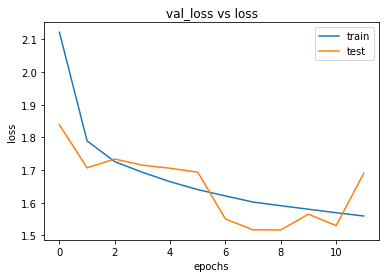

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('val_loss vs loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'])
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_loss: ', test_loss)
print('test_acc: ', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 1.5010 - accuracy: 0.4582
test_loss:  1.5009957551956177
test_acc:  0.45820000767707825


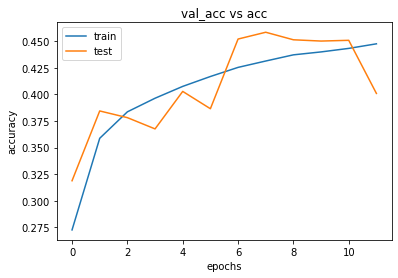

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('val_acc vs acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'])
plt.show()

In [21]:
# We can see in the val_acc vs acc diagram that in the last 3 epochs, the accuracy of the model on the train data has increased
# but the accuracy of the test data has decreased and by setting the earlystop, the model has been prevented from overfitting.
# For the solution, we can reduce the layers or turn off some neurons (dropout), or prepare or generate more data for model training, 
# or use regularization methods such as dropout, scaling, batch normalization and earlystop.
# Finally, if there is no way, we will use another architecture